# Group Project - Predicting the Winner of a Tennis Match

# 1. Introduction

Tennis is a popular racket sport throughout the world and has a large competitive scene. There are many competitions held throughout the world for tennis, to try to find the best tennis player in the world. Professional tennis players are ranked through the ATP ranking system, awarding points based on their tournament performances. For instance, a player would earn more points for making it deep into a tournament. 

In this project, we will attempt to answer the question: **“Can we predict the length of a match between two players?”** 


## Dataset Description

The dataset we will be using to create our classification model are the results of games between 2017 and 2019 of the top 500 tennis players. In this dataset, there is information about the various tournaments in the time period, information about the players that played in the tournament, and information about their wins and losses in those tournaments. There is also data about the player’s ATP rank and also how long each match was during the tournament.

# 2. Methods & Results

Firstly, we imported the tennis database into Jupyter. Then, we will transform our data to better suit our data analysis, and clean it into a tidy format. Finally, we can split the data into 75% training and 25% testing for analysis.

There are a large number of potential predictors in this dataset, many of which are potentially useless for determining how long a match is, and so further analysis is needed to determine the best set of predictor variables. We can do this using data visualizations.

After selecting the appropriate predictors, we can train a KNN (***k***
-nearest neighbors) classification model using the training data. A cross-fold validation will be performed to find the best value for ***k***. Thenly, the model will be evaluated against the testing data set.

Currently, there are columns that describe the ATP rank of the two players. We will create a new column called "average rank", which will be a mean of the two players' ranks.


## Preliminary Exploratory Data Analysis

### Library importting and graph formatting

In [1]:
## format graph
options(repr.matrix.max.rows = 6)

## import libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(GGally)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Importing dataset

In [2]:
tennis <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv", na = c("", "NA"))
glimpse(tennis)


Rows: 2806 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 2,806
Columns: 49
$ tourney_id         <chr> "2019-M020", "2019-M020", "2019-M020", "2019-M020",…
$ tourney_name       <chr> "Brisbane", "Brisbane", "Brisbane", "Brisbane", "Br…
$ surface            <chr> "Hard", "Hard", "Hard", "Hard", "Hard", "Hard", "Ha…
$ draw_size          <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,…
$ tourney_level      <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "…
$ tourney_date       <dbl> 20181231, 20181231, 20181231, 20181231, 20181231, 2…
$ match_num          <dbl> 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 2…
$ winner_id          <dbl> 105453, 106421, 105453, 104542, 106421, 104871, 105…
$ winner_seed        <dbl> 2, 4, 2, NA, 4, NA, 2, NA, 7, 4, 5, NA, NA, 6, 2, N…
$ winner_entry       <chr> NA, NA, NA, "PR", NA, NA, NA, "PR", NA, NA, NA, NA,…
$ winner_name        <chr> "Kei Nishikori", "Daniil Medvedev", "Kei Nishikori"…
$ winner_hand        <chr> "R", "R", "R", "R", "R", "R", "R", "R", "R", "R", "…
$ winner_ht     

### Cleaning and tidying dataset

minutes,rank_difference,average_rank
<dbl>,<dbl>,<dbl>
124,7,12.5
82,223,127.5
66,31,24.5
⋮,⋮,⋮
101,19,64.5
103,40,75.0
56,21,84.5


Warning message:
“Removed 66 rows containing missing values or values outside the scale range
(`geom_point()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


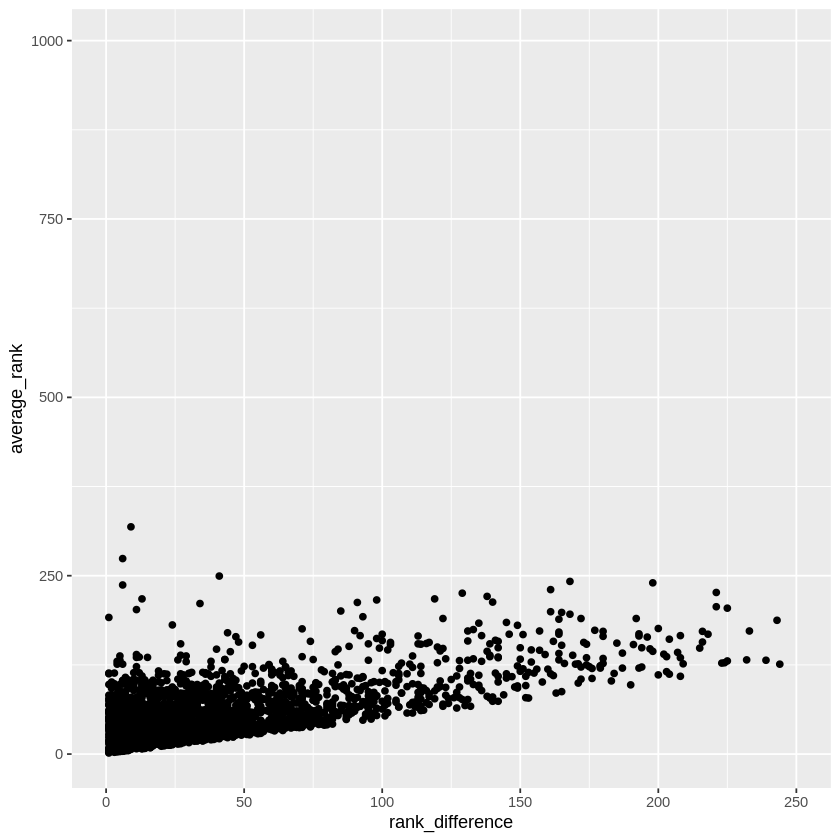

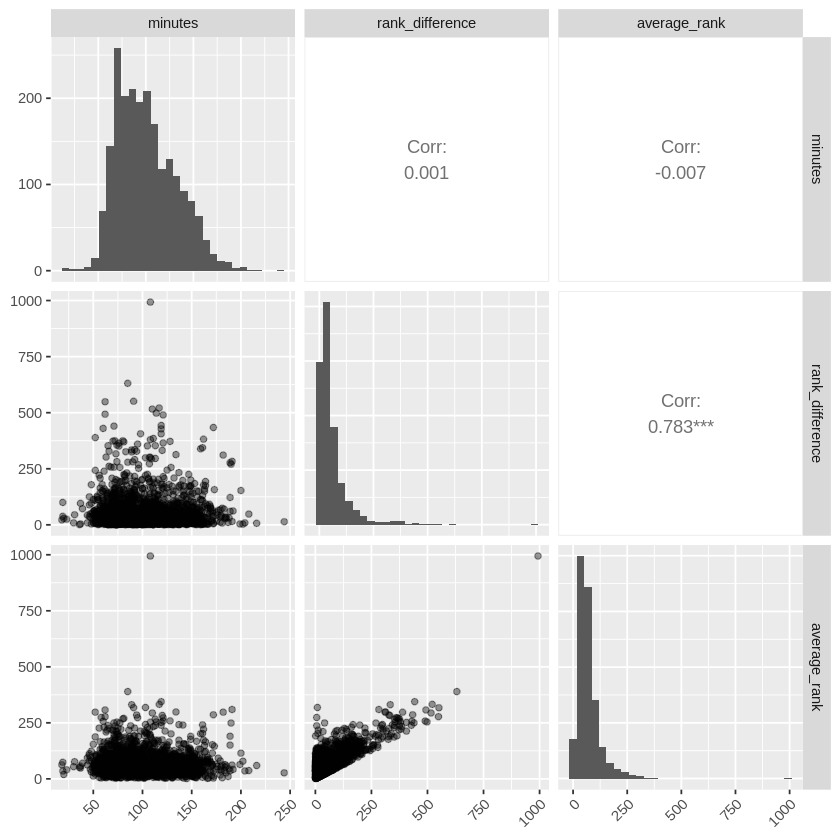

In [3]:
##Filter out best of 5 games
##Create average rank and rank difference column
##Need to remove NAs

tennis <- tennis |>
          filter(best_of == 3) |>
          mutate(rank_difference = sqrt((winner_rank - loser_rank)^2)) |>
          mutate(average_rank = (winner_rank + loser_rank)/2) |>
          select(minutes, rank_difference, average_rank) |>
          na.omit()
tennis

tennis_plot <- tennis |>
               ggplot(aes(x = rank_difference, y = average_rank)) +
                geom_point() + 
                xlim(c(0, 250)) 
tennis_plot

tennis_predictors <- tennis |>
                    ggpairs(lower = list(continuous = wrap('points', alpha = 0.4)), diag = list(continuous = "barDiag")) +
                    theme(axis.text.x = element_text(angle = 45, hjust = 1))
tennis_predictors

### Splitting the data (training and testing)

In [4]:
set.seed(69)
tennis_split <- initial_split(tennis, prop = 0.75, strata = minutes)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

### Creation of the Model

In [5]:
set.seed(69) 

lm_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression") 

tennis_recipe <- recipe(minutes ~ ., data = tennis_training) 

tennis_fit <- workflow() |>
            add_recipe(tennis_recipe) |>
            add_model(lm_spec) |>
            fit(data = tennis_training) 
tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
    (Intercept)  rank_difference     average_rank  
     100.843289        -0.007229         0.004582  


### Finding Goodness of Fit

In [6]:
set.seed(69)

lm_rmse <- tennis_fit |>
         predict(tennis_training) |>
         bind_cols(tennis_training) |>
         metrics(truth = minutes, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()
lm_rmse

[1] 30.75465

### Finding RMPSE Values from Testing Data Set

In [7]:
set.seed(69)

lm_rmspe <- tennis_fit |>
            predict(tennis_testing) |>
            bind_cols(tennis_testing) |>
            metrics(truth = minutes, estimate = .pred) |>
            filter(.metric == "rmse") |>
            select(.estimate) |>
            pull()
lm_rmspe

[1] 31.83039

### Comparing to KNN Regression (Might Delete Later) 

In [9]:
set.seed(69)

tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = minutes)

gridvals <- tibble(neighbors = seq(from = 1, to = 10))


tennis_recipe_k <- recipe(minutes ~ ., data = tennis_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())


tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                  set_engine("kknn") |>
                  set_mode("regression")



tennis_workflow <- workflow() |>
                 add_recipe(tennis_recipe_k) |>
                 add_model(tennis_spec) |>
                fit(data = tennis_training)


tennis_k <- tennis_workflow |>
            tune_grid(resamples = tennis_vfold, grid = gridvals) |>
            collect_metrics() |>
            filter(.metric == "rmse") |>
            slice_min(mean, n = 1) |>
            pull(neighbors)

tennis_spec_2 <- credit_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tennis_k) |>
                  set_engine("kknn") |>
                  set_mode("regression") 

tennis_fit_k <-  workflow() |>
                 add_recipe(tennis_recipe_k) |>
                 add_model(tennis_spec_2) |>
                 fit(data = tennis_training) 

knn_rmspe  <- tennis_fit_k |>
                    predict(tennis_testing) |>
                    bind_cols(tennis_testing) |>
                    metrics(truth = minutes, estimate = .pred)  |>
                    filter(.metric == "rmse") |>
                    pull(.estimate)
knn_rmspe

Warning message:
“tune samples were requested but there were 1624 rows in the data. 1619 will be used.”


[1] 32.74966

### Summarzation of data

### Visualizing the data

say some stuff about visualizations (need new columns)

### Expected Outcomes and Significance (Need to edit to become discussion)
o?

We expect to find the winner between two professional tennis players with a greater accuracy than other simpler forms of prediction.These findings could help professional coaches and fans discover players with higher potential and allow them to decide whom to invest their time in. These findings could also lead to future questions such as “Which player will win a certain tournament?” or on a larger scale, we could ask “Which player will be ranked the highest in the future based on their predicted tournament wins?” Overall, we hope that our predictor will be effective at determining the winner of a tennis match and that it will be useful in future applications. 

### Discussion 

- summarize what you found- 
discuss whether this is what you expected to find
- discuss what impact could such findings have?
- discuss what future questiosn could this lead to?
  to?

Fernandez, J. “Intensity of Tennis Match Play * Commentary.” British Journal of Sports Medicine, vol. 40, no. 5, 1 May 2006, pp. 387–391, https://doi.org/10.1136/bjsm.2005.023168.